# Traing MelGlow

In [1]:

import tensorflow as tf

# CONTENT_FILES = './input/clp/long'
# STYLE_FILES = './input/laplus/long'

CONTENT_FILES = './input/boy'
STYLE_FILES = './input/girl'

batch_size = 16         #batch size


windowSize = 72         # the input width of the model
vecLen = 128            # length of vector generated by siamese vector
shape = 24              # length of time axis of split specrograms to feed to generator            


learning_rate = 0.00001

delta = 2.0

max_epochs = 2      # maximum epochs

load_model_path = './saved_model/waveglow_test'  # path of the pretrained model
saved_experiment_path = './saved_model/waveglow_test'   # path of the saved model
test_waveform_file = './input/clp/short/clp_test.wav'

if not os.path.exists(saved_experiment_path):
    os.mkdir(saved_experiment_path)

    
plot_spec = True    # plot spectrum when training 
saved_epoch = 1      # save model period

pretrained = False   # If loading the pretrained model


## Reading 

In [2]:

from WaveGlow.processing import wav2spectrum
from WaveGlow.vars import sample_rate
from utils import loadFile
from glob import glob
import numpy as np


def loadData(path):
    files = glob(f'{path}/*.wav')
    data = []
    for file in files:
        x = loadFile(file, sample_rate)
        data.append(x)
    print(f'loaded {len(files)} files from {path}')
    return data

def transformData(Xs):
    ret = []
    for x in Xs:
        ret.append(wav2spectrum(x)[:, :, None].numpy())
    return ret

def splitCut(data):
    ret = []
    mini = 0
    miniFinal = 10 * shape
    for i in range(len(data) - 1):
        mini = min(data[i].shape[1], data[i + 1].shape[1])
        if mini >= windowSize and mini < miniFinal:
            miniFinal = mini
    for i in range(len(data)):
        x = data[i]
        if x.shape[1] >= windowSize:
            for n in range(x.shape[1] // miniFinal):
                ret.append(x[:, n * miniFinal: n * miniFinal + miniFinal, :])
            ret.append(x[:, -miniFinal:, :])
    return np.array(ret)


# Read waveform
x_content = loadData(CONTENT_FILES)
x_style = loadData(STYLE_FILES)

# Transform into spectrum
a_content = transformData(x_content)
a_style = transformData(x_style)

# Split spectrumgrams in chunks with equal size
data_content = splitCut(a_content)
data_style = splitCut(a_style)


print(f'sampleRate: {sample_rate}')


c:\ProgramData\Anaconda3\lib\site-packages\torch_stft\stft.py:46: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)


loaded 1 files from ./input/boy
loaded 1 files from ./input/girl
sampleRate: 22050


## Making Dataset

In [3]:

from WaveGlow.processing import n_mel_channels

@tf.function
def proc(x):
    return tf.image.random_crop(x, size = [n_mel_channels, windowSize, 1])

dsa = tf.data.Dataset.from_tensor_slices(data_content).repeat(20).map(proc, num_parallel_calls = tf.data.experimental.AUTOTUNE).shuffle(10000).batch(batch_size, drop_remainder = True)
dsb = tf.data.Dataset.from_tensor_slices(data_style).repeat(20).map(proc, num_parallel_calls = tf.data.experimental.AUTOTUNE).shuffle(10000).batch(batch_size, drop_remainder = True)

print(f'Load {len(dsa)} samples')

Load 2 samples


## Training Scheme

In [4]:

from tensorflow.keras.layers import Concatenate, Cropping2D
from WaveGlow.processing import wav2spectrum
from WaveGlow.vars import sample_rate
import matplotlib.pyplot as plt
from MelGAN.models import *
from MelGAN.loss import *
import IPython
import time



def crop(x):
    x1 = Cropping2D(((0, 0), (0, 2 * (x.shape[2] // 3))))(x)
    x2 = Cropping2D(((0, 0), (x.shape[2] // 3, x.shape[2] // 3)))(x)
    x3 = Cropping2D(((0, 0), (2 * (x.shape[2] // 3), 0)))(x)
    return x1, x2, x3

def assemble_image(x1, x2, x3):
    x = Concatenate(2)([x1, x2, x3])
    return x


@tf.function
def train_all(x, y):

    x1, x2, x3 = crop(x)
    y1, y2, y3 = crop(y)

    with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:

        gen_x_1 = model_G(x1, training = True)
        gen_x_2 = model_G(x2, training = True)
        gen_x_3 = model_G(x3, training = True)

        gen_y_1 = model_G(y1, training = True)
        gen_y_2 = model_G(y2, training = True)
        gen_y_3 = model_G(y3, training = True)


        gen = assemble_image(gen_x_1, gen_x_2, gen_x_3)

        iden_gen = model_D(gen, training = True)
        iden_ori = model_D(y, training = True)

        siam_x_1_gen = model_S(gen_x_1, training = True)
        siam_x_2_gen = model_S(gen_x_3, training = True)

        siam_x_1 = model_S(x1, training = True)
        siam_x_2 = model_S(x3, training = True)

        loss_id = (mae(y1, gen_y_1) + mae(y2, gen_y_2) + mae(y3, gen_y_3)) / 3.0

        loss_m = loss_travel(siam_x_1, siam_x_1_gen, siam_x_2, siam_x_2_gen)  + loss_siamese(siam_x_1, siam_x_2, delta)

        loss_g = g_loss_f(iden_gen)
        loss_dr = d_loss_r(iden_ori)
        loss_df = d_loss_f(iden_gen)
        loss_d = (loss_dr + loss_df) / 2.0

        loss_total = loss_g + 10.0 * loss_m + 10.0 * loss_id

    grad_gen = tape_gen.gradient(loss_total, model_G.trainable_variables + model_S.trainable_variables)
    opt_gen.apply_gradients(zip(grad_gen, model_G.trainable_variables + model_S.trainable_variables))

    grad_disc = tape_disc.gradient(loss_d, model_D.trainable_variables)
    opt_disc.apply_gradients(zip(grad_disc, model_D.trainable_variables))

    return loss_dr, loss_df, loss_g, loss_id

# Train Critic only
tf.function
def train_d(x, y):

    x1, x2, x3 = crop(x)
    
    with tf.GradientTape() as tape_disc:
        
        gen_x_1 = model_G(x1, training = True)
        gen_x_2 = model_G(x2, training = True)
        gen_x_3 = model_G(x3, training = True)

        gen = assemble_image(gen_x_1, gen_x_2, gen_x_3)

        iden_gen = model_D(gen, training = True)
        iden_ori = model_D(y, training = True)

        loss_dr = d_loss_r(iden_ori)
        loss_df = d_loss_f(iden_gen)
        loss_d = (loss_dr + loss_df) / 2.0

    grad_disc = tape_disc.gradient(loss_d, model_D.trainable_variables)
    opt_disc.apply_gradients(zip(grad_disc, model_D.trainable_variables))

    return loss_dr, loss_df

# Set learning rate
def update_lr(lr):
    opt_gen.learning_rate = lr
    opt_disc.learning_rate = lr

def train(epochs, lr = 0.0001, n_save = 3, gupt = 3):

    update_lr(lr)

    losses = {
        'loss_id': [],
        'loss_dr': [],
        'loss_df': [],
        'loss_g': []
    }

    df_list = []
    dr_list = []
    g_list = []
    id_list = []

    c = 0
    g = 0

    for epoch in range(1, max_epochs):
        
        loss_g_epoch = 0.0
        loss_id_epoch = 0.0
        loss_dr_epoch = 0.0
        loss_df_epoch = 0.0

        bef = time.time()
        for batchi, (x, y) in enumerate(zip(dsa, dsb)):

            if batchi % gupt == 0:
                dloss_t, dloss_f, gloss, idloss = train_all(x, y)
                
                loss_dr_epoch += dloss_t
                loss_df_epoch += dloss_f
                loss_id_epoch += idloss
                loss_g_epoch += gloss

            else:
                dloss_t, dloss_f = train_d(x, y)

                loss_dr_epoch += dloss_t
                loss_df_epoch += dloss_f


            df_list.append(dloss_f)
            dr_list.append(dloss_t)
            g_list.append(gloss)
            id_list.append(idloss)

            c += 1
            g += 1

            if batchi % 600 == 0:
                print(f'[Epoch {epoch}/{epochs}] [Batch {batchi}] [D loss f: {np.mean(df_list[-g:], axis = 0)} ', end = '')
                print(f'r: {np.mean(dr_list[-g:], axis = 0)}] ', end = '')
                print(f'[G loss: {np.mean(g_list[-g:], axis = 0)}] ', end = '')
                print(f'[ID loss: {np.mean(id_list[-g:])}] ', end = '')
                print(f'[LR: {lr}]')

                g = 0
            nbatch = batchi

        # save training info 
        losses['loss_g'].append(loss_g_epoch)
        losses['loss_id'].append(loss_id_epoch)
        losses['loss_dr'].append(loss_dr_epoch)
        losses['loss_df'].append(loss_df_epoch)

        print(f'Time/Batch {(time.time() - bef) / nbatch}')
        print(f'Mean D loss: {np.mean(df_list[-c:], axis = 0)} Mean G loss: {np.mean(g_list[-c:], axis = 0)} Mean ID loss: {np.mean(id_list[-c:], axis = 0)}')
        c = 0

        if epoch % n_save == 0:

            epoch_path = os.path.join(saved_experiment_path, f'epoch_{epoch}')

            if not os.path.exists(epoch_path):
                os.mkdir(epoch_path)

            if os.path.exists(test_waveform_file):
                
                x_input = loadFile(test_waveform_file, sample_rate)

                S_input = wav2spectrum(x_input).detach().cpu().numpy()

                

                H, W = S_input.shape
                S_output = np.zeros((H, W))

                for i in range(0, W - shape, shape):
                    S_output[:, i: i + shape] = np.array(model_G(S_input[:, i: i + shape].reshape(1, n_mel_channels, shape, 1), training = False)).squeeze()

                S_output[:, -shape:] = np.array(model_G(S_input[: , -shape:].reshape(1, n_mel_channels, shape, 1), training = False)).squeeze()

                # No spectrum to wave when training generator
                # x_output = spectrum2wav(S_output)

                # # save generated waveform
                # writeFile(os.path.join(epoch_path, 'ori.wav'), x_input, sample_rate)
                # writeFile(os.path.join(epoch_path, 'gen.wav'), x_output, sample_rate)


                if plot_spec:
                    print(S_input.shape)
                    print(S_output.shape)
                    fig, axs = plt.subplots(ncols = 2)
                    axs[0].imshow(np.flip(S_input, -2), cmap = None)
                    axs[0].axis('off')
                    axs[0].set_title('Source')
                    axs[1].imshow(np.flip(S_output, -2), cmap = None)
                    axs[1].axis('off')
                    axs[1].set_title('Generated')
                    plt.show()

                model_S.save_weights(os.path.join(epoch_path, 'siam.h5'))
                model_G.save_weights(os.path.join(epoch_path, 'gen.h5'))
                model_D.save_weights(os.path.join(epoch_path, 'critic.h5'))

                print(f'Save model and generate waveform at epoch {epoch}')

    return losses, df_list, dr_list, g_list, id_list


## Train MelGAN

[Epoch 1/2] [Batch 0] [D loss f: 0.9696550369262695 r: 1.0392616987228394] [G loss: 0.030344929546117783] [ID loss: 5.036352157592773] [LR: 1e-05]
Time/Batch 25.380834102630615
Mean D loss: 0.9759758114814758 Mean G loss: 0.030344929546117783 Mean ID loss: 5.036352157592773
(80, 301)
(80, 301)


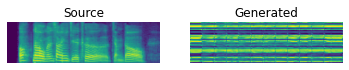

Save model and generate waveform at epoch 1


In [5]:

from tensorflow.keras.optimizers import Adam
import pickle as pkl


if pretrained:
    model_S, model_G, model_D = load(load_model_path, n_mel_channels, shape, vecLen)
else:
    model_S, model_G, model_D = build(n_mel_channels, shape, vecLen)


opt_gen = Adam(learning_rate, 0.5)
opt_disc = Adam(learning_rate, 0.5)

losses, df_list, dr_list, g_list, id_list = train(max_epochs, lr = learning_rate, n_save = saved_epoch, gupt = 3)


info = {
    'loss': losses,
    'g_list': g_list,
    'df_list': df_list, 
    'dr_list': dr_list,
    'id_list': id_list,
    'epochs': max_epochs,
    'learning_rate': learning_rate,
    'input_shape': (n_mel_channels, windowSize, 1),
    'vecLen': vecLen,
    'batch_size': batch_size,
    'saved_model_path': saved_experiment_path,
    'load_model_path': load_model_path,
    'pretrained': pretrained
}

with open(os.path.join(saved_experiment_path, 'train_info.pkl'), 'wb') as f:
    pkl.dump(info, f)

model_S.save_weights(os.path.join(saved_experiment_path, 'siam.h5'))
model_G.save_weights(os.path.join(saved_experiment_path, 'gen.h5'))
model_D.save_weights(os.path.join(saved_experiment_path, 'critic.h5'))


## Show training process

In [6]:

# from utils import plot_curve
# print(losses['loss_g'])

# print(losses['loss_df'])

# total_loss = np.array(losses['loss_S']) + np.array(losses['loss_G']) + np.array(losses['loss_D'])
# print(losses.keys())
# plot_curve(losses['loss_D'], losses['loss_G'], total_loss, 'Critic loss', 'Generator loss ', 'Total loss', False)
# plot_curve(losses['loss_g'])
# print(losses['loss_m'])
# print(losses['loss_g'])
# print(losses['loss_GS'])




## Load generator

In [3]:
from WaveGlow.vars import n_mel_channels
from MelGAN.models import *
import tensorflow as tf

model_G = build_generator((n_mel_channels, shape, 1))
model_G.load_weights(os.path.join(load_model_path, 'gen.h5'))


## Making WaveGlow Dataset

In [7]:


from WaveGlow.vars import n_mel_channels, hop_length
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numba import cuda 
import numpy as np
import torch


crop_length = hop_length * shape

print(f'Use {crop_length} as sample length')


class myDataset(Dataset):
    def __init__(self, wave, spec, sampleNumber = 100):

        self.spec = []
        self.wave = []

        for x, s in zip(wave, spec):
            
            H, W, _ = s.shape
            
            # crop random samples
            indices = np.random.randint(W - crop_length // hop_length, size = sampleNumber)

            for i in indices:

                j = i * hop_length

                S = s[:, i: i + crop_length // hop_length]
                S = model_G(S[None, :, :, :], training = False)
                S = np.array(S).squeeze()

                for _ in range(crop_length // shape):
                    pass

                self.spec.append(torch.tensor(S, requires_grad = False))
                self.wave.append(torch.tensor(x[j: j + crop_length], requires_grad = False))             

    def __getitem__(self, index):
        return self.spec[index], self.wave[index]

    def __len__(self):
        return len(self.spec) 


dataset = myDataset(x_style, a_style)

train_loader = DataLoader(
    dataset, batch_size = 4
)


print(f'Load {len(dataset)} samples')


# clear memory used for tensorflow 
device = cuda.get_current_device()
device.reset()



Use 6144 as sample length
Load 100 samples


## Train WaveGlow Model

In [8]:

from IPython.display import clear_output
import torch

PRETRAINED_MODEL = './WaveGlow/waveglow_256channels_universal_v5.pt'
wave = torch.load(PRETRAINED_MODEL)['model']
wave = wave.remove_weightnorm(wave)
clear_output()


## Transfer Learning on WaveGlow

In [11]:

from glow import WaveGlowLoss

learning_rate_waveglow = 0.0001

max_epochs_waveglow = 1

# If gpu is available
if torch.cuda.is_available():  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

loss_metric =  WaveGlowLoss(sigma = 1.0)



In [13]:


import torch.optim as optim
from tqdm import tqdm

optimizer = optim.Adam( 
    wave.parameters(),
    lr = learning_rate_waveglow
)


wave.to(device)

wave.train()


for epoch in range(1, max_epochs_waveglow + 1):

    with tqdm(train_loader, unit = 'batch') as tepoch:

        for s, x in tepoch:

            tepoch.set_description(f'Training Epoch {epoch:03d}/{max_epochs_waveglow:03d}')

            optimizer.zero_grad()

            
            x = x.to(device)
            s = s.to(device)
        

            loss = loss_metric(wave((s, x)))
                
            loss.backward()

            optimizer.step()

            tepoch.set_postfix({'loss': loss.item()})


torch.save(wave.state_dict(), os.path.join(saved_experiment_path, 'wave.pt'))



Training Epoch 001/001: 100%|██████████| 25/25 [00:11<00:00,  2.12batch/s, loss=-3.69]


# Test model

In [1]:

load_model_path = './saved_model/waveglow_test'         # path of the pretrained model
saved_experiment_path = './saved_model/waveglow_test'   # path of the saved model
test_waveform_file = './input/clp/short/clp_test.wav'   # path of the test waveform

shape = 24


In [2]:


from WaveGlow.processing import wav2spectrum, Denoiser
from WaveGlow.vars import n_mel_channels, sample_rate
from IPython.display import clear_output
from utils import loadFile, writeFile
from MelGAN.models import *
from numba import cuda
import numpy as np
import torch

# load generator
model_G = build_generator((n_mel_channels, shape, 1))
model_G.load_weights(os.path.join(load_model_path, 'gen.h5'))

# load wave file

x_test = loadFile(test_waveform_file, sample_rate)

s_test = wav2spectrum(x_test).numpy()

# generate spectrum
H, W = s_test.shape
s_output = np.zeros((H, W))

for i in range(0, W - shape, shape):
    s_output[:, i: i + shape] = np.array(model_G(s_test[:, i: i + shape].reshape(1, n_mel_channels, shape, 1), training = False)).squeeze()

s_output[:, -shape:] = np.array(model_G(s_test[: , -shape:].reshape(1, n_mel_channels, shape, 1), training = False)).squeeze()


# clear memory used for tensorflow 
device = cuda.get_current_device()
device.reset()


# load WaveGlow model
PRETRAINED_MODEL = './WaveGlow/waveglow_256channels_universal_v5.pt'
wave = torch.load(PRETRAINED_MODEL)['model']
wave = wave.remove_weightnorm(wave)
clear_output()


# If gpu is available
if torch.cuda.is_available():  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')




wave.eval()
wave.to(device)

model = Denoiser(wave)
model.to(device)

# transforming to waveform
mel = torch.FloatTensor(s_output[None, :, :]).to(device)

with torch.no_grad(): 
    audio = wave.infer(mel, sigma = 1.0)
    audio = model(audio)

audio = audio.squeeze()
audio = audio.cpu().numpy()


writeFile('./output/waveglow.wav', audio, sample_rate)



c:\ProgramData\Anaconda3\lib\site-packages\torch_stft\stft.py:46: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
c:\ProgramData\Anaconda3\lib\site-packages\torch_stft\util.py:40: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  win_sq = librosa_util.pad_center(win_sq, n_fft)


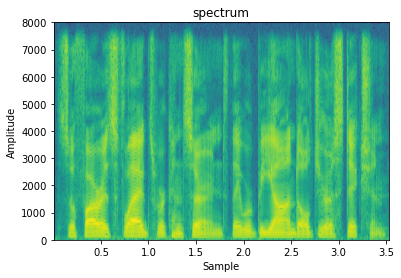

torch.Size([1, 80, 221])
tensor([[[ -5.7594,  -5.4743,  -4.7603,  ...,  -4.6737,  -4.5745,  -4.7844],
         [ -6.9627,  -6.5036,  -5.5992,  ...,  -5.2161,  -5.2419,  -5.2046],
         [ -7.1134,  -6.8969,  -6.6927,  ...,  -6.0730,  -6.7213,  -6.2480],
         ...,
         [ -9.7207,  -9.2766,  -7.5424,  ...,  -9.6099,  -9.1215,  -9.1055],
         [-10.0585,  -9.4943,  -7.7646,  ...,  -9.5460,  -8.7261,  -8.6745],
         [-10.0164,  -9.2291,  -8.0429,  ...,  -9.1654,  -8.5082,  -8.4722]]],
       device='cuda:0')


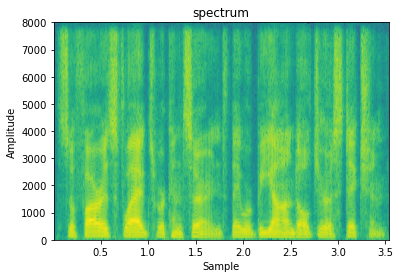

In [22]:

from WaveGlow.vars import sample_rate, MAX_WAV_VALUE
from utils import plot_spectrogram_with_raw_signal
from WaveGlow.processing import wav2spectrum
from scipy.io.wavfile import read, write
from utils import loadFile, writeFile
import matplotlib.pyplot as plt
import numpy as np
import torch










# x_test = loadFile('./input/boy/input_boy.wav', sample_rate) * MAX_WAV_VALUE
sample_rate, x_test = read('./input/boy/input_boy.wav')

plot_spectrogram_with_raw_signal(x_test, sample_rate)

s_test = wav2spectrum(torch.tensor(x_test))

# fig, axs = plt.subplots(ncols = 2)
# axs[0].imshow(np.flip(s_test.numpy(), -2), cmap=None)
# axs[0].axis('off')
# axs[0].set_title('librosa')
# axs[1].imshow(np.flip(s_test_.numpy(), -2), cmap=None)
# axs[1].axis('off')
# axs[1].set_title('scipy')
# plt.show()                                  




s_test = s_test.unsqueeze(0)

wave.cuda().eval()
s_test = torch.autograd.Variable(s_test.cuda())

print(s_test.shape, s_test, sep = '\n')

with torch.no_grad():
    audio = wave.infer(s_test, sigma = 1.0)
    audio = audio * MAX_WAV_VALUE

audio = audio.squeeze()
audio = audio.cpu().numpy()


writeFile('./output/waveglow.wav', audio, sample_rate)


plot_spectrogram_with_raw_signal(audio, sample_rate)

